In [30]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import pandas_market_calendars as mcal

import warnings
warnings.filterwarnings('ignore')

In [31]:
def nyse_holidays():
    nyse = mcal.get_calendar('NYSE')
    holidays = nyse.holidays()
    nyse_holidays = holidays.holidays
    
    return nyse_holidays

# shift dates if they fall on a weekend/trading holiday
def get_prev_business_date(date, holidays):
    if date.isoweekday() in set((6, 7)):
        #if date falls on a weekend, move the date back
        date -= pd.offsets.BDay(n = date.isoweekday() % 5)
    elif date in holidays:
        #if date is a NYSE trading holiday, move the date back
        date -= pd.offsets.BDay(n=1)  # get prev day
        # now if the new date is on a weekend, move it back 
        if date.isoweekday() in set((6, 7)):
            date -= pd.offsets.BDay(n = date.isoweekday() % 5)

    return date

In [32]:
#Load Price Data
def get_oil_prices():
    wd = os.getcwd()

    df = pd.read_excel(wd+'/Data/'+'WTI.xlsx')
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime('%m-%d-%Y')
    df.set_index('Date', inplace=True)
    
    return df

In [33]:
def get_ma(df, column, freq='monthly'):
    df[df.columns[column] + '_temp'] = df[df.columns[column]]
    
    if freq=='monthly':
        window = 22
    elif freq=='biweekly':
        window = 10
    
    for i in range(0, len(df[df.columns[column]])-window):
        df.iloc[i, column] = np.mean(df.iloc[i:i+window, -1])
        
    drop_col_name = df.columns[column] + '_temp'
    df = df.loc[:, ~df.columns.isin([drop_col_name])]
    
    return df

In [34]:
#Load Features

def get_features(df, sma=True):
    if sma:
        df = get_ma(df, 0, 'monthly')
    
    wd = os.getcwd()
    xlsx_files = glob.glob(os.path.join(wd, 'Data', "*.xlsx"))
    holidays = nyse_holidays()
    daily_data = ['DowJones', 'SPX', 'USDEUR', 'DAX', 'NG1', 'Nikkei', 'HangSeng', 'GT10']

    for file in xlsx_files:
        data_name = file.split("\\")[-1].split('.')[0]
        data_name = data_name.replace(" ", "_")

        if data_name == 'WTI':
            continue

        df_temp = pd.read_excel(file)
        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        #print(data_name)
        if data_name in daily_data:
            df_temp['Date'] = df_temp['Date'].dt.strftime('%m-%d-%Y')
            df_temp.set_index('Date', inplace=True)
        else:
            df_temp['Artificial Date'] = df_temp['Date'].apply(lambda x: get_prev_business_date(x, holidays))
            df_temp['Artificial Date'] = df_temp['Artificial Date'].dt.strftime('%m-%d-%Y')
            df_temp = df_temp.drop(columns=['Date'])
            df_temp.set_index('Artificial Date', inplace=True)

        try:
            df[df_temp.columns[0] + '_' + data_name] = df_temp[df_temp.columns[0]]
        except ValueError:
            print(data_name, "Error")

    #backfill data for other frequencies
    df.fillna(method='bfill', inplace=True)
    idx = list(df.index).index('12-31-2020')
    df = df.iloc[idx:,:]
    
    return df



In [35]:
def get_raw_data(df, freq = 'daily'):
    if freq == 'weekly':
        df = df.iloc[::5, :]
    
    #Add Sign and returns Data point
    df['PX_Sign'] = np.sign(df['PX_LAST'] - df['PX_LAST'].shift(-1))
    df.loc[df.PX_Sign == 0, 'PX_Sign'] = int(1)
    df['Returns'] = df['PX_LAST']/df['PX_LAST'].shift(-1) - 1
    
    return df
    

In [36]:
def plot_prices_graph(df):
    ax = df_t[df_t.columns[0]][::-1].plot()
    ax.set_ylabel("WTI Price")
    ax.set_title('WTI Price (1990-2021)')

In [37]:
prices = ['PX_LAST']
classification = ['PX_Sign']
returns = ['Returns']

In [38]:
#Dict for frequency adjustment
cols_freq = {
    'PX_LAST':"daily",
    'PX_VOLUME':"daily",
    'PX_LAST_DowJones':"daily",
    'PX_MID_GT10':"daily",
    'PX_LAST_HangSeng':"daily",
    'PX_LAST_Nikkei':"daily",
    'PX_LAST_SPX':"daily",
    'PX_LAST_USDEUR':"daily",
    'PX_LAST_NG1':"daily",
    'PX_LAST_DAX':"daily",
    'PX_LAST_US_daily_prod':"monthly",
    'PX_LAST_Cass_Freight_Rates':"monthly",
    'PX_LAST_Canada_daily_prod':"monthly",
    'PX_LAST_Russia_daily_prod':"monthly",
    'PX_LAST_OPEC_daily_prod':"monthly",
    'PX_LAST_US_Inflation':"monthly",
    'PX_LAST_Europe_Inflation':"monthly",
    'PX_LAST_Europe_IndProd_exConstruction':"monthly",
    'PX_LAST_Russia_Industrial_Production':"monthly",
    'PX_LAST_US_IndProd_Index':"monthly",
    'PX_LAST_China_GDP':"quarterly",
    'PX_LAST_Germany_GDP':"quarterly",
    'PX_LAST_Japan_GDP':"quarterly",
    'PX_LAST_Russia_GDP':"quarterly",
    'PX_LAST_US_GDP':"quarterly",
    'PX_Sign':'daily',
    'Returns':'daily'
}

In [16]:
def daily_lag(df, column, lag):
    lag = lag+1
    if column==0:
        for i in range(1, lag):
            #creating new column here since column==0 is target
            
            df[df.columns[column] + '_t-' + str(i)] = df[df.columns[column]].shift(-i)
            cols_freq[df.columns[column]+'_t-'+str(i)] = "daily"
    else:
        for i in range(1, lag):
            #replacing old column here and renaming
            df[df.columns[column]] = df[df.columns[column]].shift(-i)
            df.rename(columns={df.columns[column]:df.columns[column]+'_t-'+str(i)}, inplace=True)
            new_col = df.columns[column]
            cols_freq[new_col] = "daily"
    
    return df


def ma(df, column, col_freq = "monthly", freq='daily'):
    if col_freq == "monthly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        if freq == 'daily':
            window = 22
        elif freq == 'weekly':
            window = 4
        
        for i in range(0, len(df[df.columns[column]])-window):
            df.iloc[i, column] = np.mean(df.iloc[i:i+window, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA22'}, inplace=True)
        cols_freq[df.columns[column]] = "monthly"
    elif col_freq == "quarterly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        if freq == 'daily':
            window = 65
        elif freq == 'weekly':
            window = 13
        
        for i in range(0, len(df[df.columns[column]])-window):
            df.iloc[i, column] = np.mean(df.iloc[i:i+window, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA65'}, inplace=True)
        cols_freq[df.columns[column]] = "quarterly"
    
    return df


def lag_data(df, column, col_freq = "monthly", freq='daily'):
    if col_freq == "monthly":
        if freq == 'daily':
            lag = 22
        elif freq == 'weekly':
            lag = 4
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-lag)
        df.rename(columns={df.columns[column]:df.columns[column]+'_M'}, inplace=True)
    elif col_freq == "quarterly":
        if freq == 'daily':
            lag = 65
        elif freq == 'weekly':
            lag = 13
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-lag)
        df.rename(columns={df.columns[column]:df.columns[column]+'_Q'}, inplace=True)
    else:
        raise ValueError("Frequency invalid")
    
    return df

def get_lag_ma_data(df, daily_lags = 1, cols_freq=cols_freq, freq='daily'):
    for i in range(len(df.columns)):
        column_name = df.columns[i]
        #print(column_name)
        if cols_freq[column_name] == 'daily':
            df = daily_lag(df, i, daily_lags)
        else:
            df = lag_data(df, i, cols_freq[column_name], freq)
            df = ma(df, i, cols_freq[column_name], freq)
            
    return df

In [17]:
def one_day_change(df, column, freq):
    #creating new column here, will drop old column later in get_diffs
    if freq=='daily':
        df[df.columns[column] + '_1D_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-1)
    elif freq=='weekly':
        df[df.columns[column] + '_1W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-1)

    return df

def two_week_change(df, column, freq):
    #creating new column here, will drop old column later in get_diffs
    if freq=='daily':
        df[df.columns[column] + '_2W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-10)
    elif freq=='weekly':
        df[df.columns[column] + '_2W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-2)
    
    return df

def one_month_change(df, column, freq):
    #creating new column here, will drop old column later in get_diffs
    if freq=='daily':
        df[df.columns[column] + '_1M_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-22)
    elif freq=='weekly':
        df[df.columns[column] + '_1M_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-4)
    return df

def get_diffs(df, target, cols_freq=cols_freq, freq='daily', drop=True):
    cols = []
    for i in range(1, len(df.columns)):
        column_name = df.columns[i]
        #collecting old columns to drop later
        cols.append(column_name)
        
        if cols_freq[column_name] == 'daily':
            df = one_day_change(df, i, freq)
            df = two_week_change(df, i, freq)
            df = one_month_change(df, i, freq)
        elif cols_freq[column_name] == 'monthly':
            df = two_week_change(df, i, freq)
            df = one_month_change(df, i, freq)
        elif cols_freq[column_name] == 'quarterly':
            df = one_month_change(df, i, freq)
        
    #dropping old columns
    target_lagged = df.columns[0] + '_t-1'
    cols.remove(target_lagged)
    #print(cols)
    df = df.loc[:, ~df.columns.isin(cols)]
    
    return df

In [18]:
def make_regime(df, end, start=0):
    if start==0 and end==0:
        return df
    
    if start!=0:
        st_idx = list(df.index).index(start)
    else:
        st_idx = 0
    end_idx = list(df.index).index(end)
    df_reg = df.iloc[st_idx:end_idx,:]
    return df_reg

In [43]:
def do_pca(feature_set):
    n = len(feature_set)
    d = len(feature_set.columns)
    
    x = feature_set.values #numpy array
    x_scaled = StandardScaler().fit_transform(x)
    feature_set = pd.DataFrame(x_scaled)
    
    k = int(round(d/3, 0)) #no. of reduced features needed
    w0 = np.random.randn(k, d) #Y is (n x d) dimensional
    wt = w0
    I = 10 #no. of iterations for alternating minimisation
    residuals_am = np.zeros(I)

    for t in range(I):
        wt_1 = wt
        gram_w = np.matmul(wt_1, wt_1.T)
        gram_w_inv = np.linalg.inv(gram_w)
        xt = np.zeros((n,k))
        for i in range(n):
            xt[i] = np.matmul(feature_set.iloc[i].values, np.matmul(wt_1.T, gram_w_inv))

        gram_x = np.matmul(xt.T, xt)
        gram_x_inv = np.linalg.inv(gram_x)
        wt = np.zeros((k,d))
        for j in range(d):
            wt[:,j] = np.matmul(np.matmul(gram_x_inv, xt.T), feature_set.iloc[:,j])

        residuals_am[t] = np.linalg.norm(feature_set.values-np.matmul(xt, wt))
        
    return xt, k, residuals_am

In [20]:
def get_final_data(df, features, regime, target=classification, freq='daily', pca=False):
    if target != prices:
        features = ['PX_LAST'] + features
    
    df_trial = get_lag_ma_data(df[target + features], freq=freq)
    df_trial = get_diffs(df_trial, target, freq=freq)
    
    df_trial = df_trial.dropna()
    df_trial = df_trial[::-1]
    
    df_reg = make_regime(df_trial, end=regime[1], start=regime[0])
    
    df_target = df_reg[target]
    df_features_raw = df_reg.iloc[:, 1:]
    
    if pca:
        d = len(df_features_raw.columns)
        xt, k, res = do_pca(df_features_raw)
        df_features = pd.DataFrame(xt)
        df_features.index = df_features_raw.index
        print("PCA reduced features from {} to {}".format(d, k))
        print("Error = {}".format(res[-1]))
    else:
        df_features = df_features_raw.copy()
    
    if target == classification:
        df_target = df_target.astype(int)
    
    return df_target, df_features

In [21]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

def get_data_splits(target, features):
    train_n = int(len(target) * 0.8)
    train_x = features[:train_n].to_numpy()
    train_y = target[:train_n].to_numpy()
    test_x = features[train_n:].to_numpy()
    test_y = target[train_n:].to_numpy()

    splits = TimeSeriesSplit(n_splits=100)

    split_train_x = []
    split_val_x = []
    split_train_y = []
    split_val_y = []

    for train_index, val_index in splits.split(train_x):
        split_train_x.append(train_x[train_index])
        split_train_y.append(train_y[train_index])
        split_val_x.append(train_x[val_index])
        split_val_y.append(train_y[val_index])
        
    split_data = [split_train_x, split_train_y, split_val_x, split_val_y]
    train_data = [train_x, train_y]
    test_data = [test_x, test_y]
    
    return split_data, train_data, test_data

### Classification Models

In [22]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def svc_hinge(split_data, iters=1000):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    lambdas = np.arange(0.001, 0.101, 0.02)
    Hloss = []
    Rh = []
    count = 0
    
    for lam in lambdas:
        scaler = RobustScaler()
        clf = svm.LinearSVC(penalty='l2', loss='hinge', fit_intercept=True,
                            C=(1/lam), max_iter=iters, random_state=42)
        acc = []
        
        for i in range(len(split_train_x)):
            #wrapped_model = TransformedTargetRegressor(regressor=clf, transformer=RobustScaler())
            #model = wrapped_model.fit(split_train_x[i], split_train_y[i].reshape(len(split_train_y[i])))
            
            scaled_fit_train = scaler.fit(split_train_x[i])
            split_train_x[i] = scaled_fit_train.transform(split_train_x[i])
            split_val_x[i] = scaled_fit_train.transform(split_val_x[i])
            
            model = clf.fit(split_train_x[i], split_train_y[i].reshape(-1,1))
            pred = model.predict(split_val_x[i])
            acc.append(np.mean(pred != split_val_y[i]))
            count+=1
            #print(count)
        Hloss.append(np.mean(acc))
        Rh.append(lam)
    l_star = Rh[np.argmin(Hloss)]
    print('Lambda* = {}'.format(l_star))
    print('SVM Validation Error Rate = {}'.format(Hloss[np.argmin(Hloss)]))
    return Hloss, Rh, l_star

def svc_hinge_test(train_data, test_data, l_star, iters=10000):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    scaler = RobustScaler()
    scaled_fit_train = scaler.fit(train_x)
    
    train_x_std = scaled_fit_train.transform(train_x)
    test_x_std = scaled_fit_train.transform(test_x)
    
    
    model = svm.LinearSVC(penalty='l2', loss='hinge', fit_intercept=True,
                            C=(1/l_star), max_iter=iters, random_state=42)
    
    train_y = train_y.reshape(-1,1)
    model.fit(train_x_std, train_y)
    pred = model.predict(test_x_std)
    mse = np.mean(pred!=test_y)
    
    return pred, mse

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def decision_tree(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    maxnodes = np.arange(3, 18, 1)
    maxnodes_misclas = []
    
    for maxnode in maxnodes:
        misclas = []
        
        for i in range(len(split_train_x)):
            model = tree.DecisionTreeClassifier(random_state=42, max_leaf_nodes = maxnode)
            model = model.fit(split_train_x[i], split_train_y[i])
            yhat = model.predict(split_val_x[i])
            misclas.append(np.mean(yhat!=split_val_y[i]))

        maxnodes_misclas.append(np.mean(misclas))
    
    best_nodes = maxnodes[np.argmin(maxnodes_misclas)]
    print('Best Max Nodes = {}'.format(best_nodes))
    print('Decision Tree Validation Error Rate = {}'.format(maxnodes_misclas[np.argmin(maxnodes_misclas)]))
    
    return maxnodes_misclas, best_nodes

def decision_tree_test(train_data, test_data, maxnodes):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    tr_model = tree.DecisionTreeClassifier(random_state=2, max_leaf_nodes = maxnodes)
    tr_model = tr_model.fit(train_x, train_y)
    pred = tr_model.predict(test_x)
    error = np.mean(pred!=test_y)
    
    return pred, error



In [24]:
from sklearn.linear_model import LogisticRegression

def logistic(split_data, iters=1000):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    lambdas = np.arange(0.01, 1.01, 0.20)
    Lloss = []
    Rl = []
    count = 0
    
    for lam in lambdas:
        scaler = RobustScaler()
        clf = LogisticRegression(penalty='l2', C=(1/lam), max_iter=iters, random_state=42,
                            fit_intercept=True)
        acc = []
        
        for i in range(len(split_train_x)):
            #wrapped_model = TransformedTargetRegressor(regressor=clf, transformer=RobustScaler())
            #model = wrapped_model.fit(split_train_x[i], split_train_y[i].reshape(len(split_train_y[i])))
            
            scaled_fit_train = scaler.fit(split_train_x[i])
            split_train_x[i] = scaled_fit_train.transform(split_train_x[i])
            split_val_x[i] = scaled_fit_train.transform(split_val_x[i])
            
            model = clf.fit(split_train_x[i], split_train_y[i].reshape(-1,1))
            pred = model.predict(split_val_x[i])
            acc.append(np.mean(pred != split_val_y[i]))
            count+=1
            #print(count)
        Lloss.append(np.mean(acc))
        Rl.append(lam)
    l_star = Rl[np.argmin(Lloss)]
    print('Lambda* = {}'.format(l_star))
    print('Logistic Validation Error Rate = {}'.format(Lloss[np.argmin(Lloss)]))
    return Lloss, Rl, l_star

def logistic_test(train_data, test_data, l_star, iters=1000):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    scaler = RobustScaler()
    scaled_fit_train = scaler.fit(train_x)
    
    train_x_std = scaled_fit_train.transform(train_x)
    test_x_std = scaled_fit_train.transform(test_x)
    
    model = LogisticRegression(penalty='l2', C=(1/l_star), max_iter=iters, random_state=42, 
                             fit_intercept=True)
    
    train_y = train_y.reshape(-1,1)
    model.fit(train_x_std, train_y)
    pred = model.predict(test_x_std)
    mse = np.mean(pred!=test_y)
    
    return pred, mse

### Regression Models

In [25]:
def lasso(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alphas = np.arange(0.05, 1.01, 0.05)
    alpha_mse = []
    
    for alpha in alphas:
        transformer = RobustScaler
        model = linear_model.Lasso(alpha=alpha)
        mse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        alpha_mse.append(np.mean(mse))
    a_star = alphas[np.argmin(alpha_mse)]
    print('Lasso Alpha* = {}'.format(alphas[np.argmin(alpha_mse)]))
    print('Lasso Validation RMSE = {}'.format(np.sqrt(alpha_mse[np.argmin(alpha_mse)])))
    return alpha_mse, a_star

def lasso_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.Lasso(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    mse = np.mean((pred-test_y)**2)
    
    return pred, mse

In [26]:
def huber(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alphas = np.arange(0.05, 1.01, 0.05)
    alpha_mse = []
    
    for alpha in alphas:                     
        transformer = RobustScaler
        model = linear_model.HuberRegressor(alpha=alpha)
        mse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        alpha_mse.append(np.mean(mse))
    a_star = alphas[np.argmin(alpha_mse)]
    print('Huber Alpha* = {}'.format(a_star))
    print('Huber Validation RMSE = {}'.format(np.sqrt(alpha_mse[np.argmin(alpha_mse)])))
    return alpha_mse, a_star

def huber_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.HuberRegressor(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    pred = wrapped_model.predict(test_x)
    mse = np.mean((pred-test_y)**2)
    
    return pred, mse

In [41]:
from sklearn.ensemble import RandomForestRegressor

def RF_regressor(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    estimators = np.arange(70, 130, 10)
    estimator_mse = []
    
    for estimator in estimators:
        model = RandomForestRegressor(n_estimators=estimator)
        mse = []
        model.fit(split_train_x[-1], split_train_y[-1])
        yhat = model.predict(split_val_x[-1])
        mse.append(np.mean((yhat-split_val_y[-1])**2))
        estimator_mse.append(np.mean(mse))
    best_est = estimators[np.argmin(estimator_mse)]
    print('Random Forest Efficient Estimator = {}'.format(best_est))
    print('Random Forest Validation RMSE = {}'.format(np.sqrt(estimator_mse[np.argmin(estimator_mse)])))
    return estimator_mse, best_est

def RF_regressor_test(train_data, test_data, best_est):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = RandomForestRegressor(n_estimators=best_est)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    mse = np.mean((pred-test_y)**2)
    
    return pred, mse

In [28]:
def classification_models(features, regime_period, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=classification,
                                            freq=freq,
                                            pca=pca)
    
    split_data, train_data, test_data = get_data_splits(df_target, df_features)
    
    Hloss, Rh, hinge_lambda = svc_hinge(split_data)
    hinge_yhat, hinge_error = svc_hinge_test(train_data, test_data, hinge_lambda)
    print("SVM Test error rate = ", hinge_error, '\n')
    
    Lloss, Rl, log_lambda = logistic(split_data)
    log_yhat, log_error = logistic_test(train_data, test_data, log_lambda)
    print("Logistic Test error rate = ", log_error, '\n')
    
    trees_maxnode_misclas, trees_max_nodes = decision_tree(split_data)
    trees_yhat, trees_error = decision_tree_test(train_data, test_data, trees_max_nodes)
    print("Decision Trees Test error rate = ", trees_error, '\n')
    
    yhats = [hinge_yhat, log_yhat, trees_yhat]
    errors = [hinge_error, log_error, trees_error]
    
    return yhats, errors

In [29]:
def plot_graph(yhat, test_y):
    plt.plot(yhat, label='pred')
    plt.plot(test_y, label='true')
    plt.legend()
    plt.show()

In [44]:
def regression_models(features, regime_period, target=prices, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=target,
                                            freq=freq,
                                            pca=pca)
    
    split_data, train_data, test_data = get_data_splits(df_target, df_features)
    test_x = test_data[0]
    test_y = test_data[1]
    
    lasso_mse, lasso_alpha = lasso(split_data)
    lasso_pred, lasso_mse = lasso_test(train_data, test_data, lasso_alpha)
    lasso_rmse = np.sqrt(lasso_mse)
    print("Lasso Test RMSE = ", lasso_rmse)
    plot_graph(lasso_pred, test_y)
    
    huber_mse, huber_alpha = huber(split_data)
    huber_pred, huber_mse = huber_test(train_data, test_data, huber_alpha)
    huber_rmse = np.sqrt(huber_mse)
    print("Huber Test RMSE = ", huber_rmse)
    plot_graph(huber_pred, test_y)
    
    RF_mse, RF_best_est = RF_regressor(split_data)
    rf_pred, rf_mse = RF_regressor_test(train_data, test_data, RF_best_est)
    rf_rmse = np.sqrt(rf_mse)
    print("RandomForest Test RMSE = ", rf_rmse)
    plot_graph(rf_pred, test_y)
    
    hyper = [lasso_alpha, huber_alpha, RF_best_est]
    pred = [lasso_pred, huber_pred, rf_pred]
    rmse = [lasso_rmse, huber_rmse, rf_rmse]
    
    return pred, rmse, hyper

In [31]:
# Feature Categories by Type
fin_indices = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10',
           'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX',
           'PX_LAST_USDEUR']
nat_gas = ['PX_LAST_NG1']
gdp = ['PX_LAST_China_GDP', 'PX_LAST_Germany_GDP', 'PX_LAST_Japan_GDP',
       'PX_LAST_Russia_GDP', 'PX_LAST_US_GDP']
oil_prod = ['PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod',
            'PX_LAST_OPEC_daily_prod', 'PX_LAST_US_daily_prod']
freight = ['PX_LAST_Cass_Freight_Rates']
inflation = ['PX_LAST_US_Inflation', 'PX_LAST_Europe_Inflation']
ind_prod = ['PX_LAST_Europe_IndProd_exConstruction', 
            'PX_LAST_Russia_Industrial_Production',
            'PX_LAST_US_IndProd_Index']

In [32]:
# Feature Categories by Date Range
feat_1992 = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10', 
             'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX', 
             'PX_LAST_USDEUR', 'PX_LAST_NG1', 'PX_LAST_China_GDP', 
             'PX_LAST_Germany_GDP', 'PX_LAST_US_GDP', 'PX_LAST_US_daily_prod', 
             'PX_LAST_Cass_Freight_Rates', 'PX_LAST_US_Inflation', 
             'PX_LAST_Europe_IndProd_exConstruction', 'PX_LAST_US_IndProd_Index']
feat_1996 = feat_1992 + ['PX_LAST_Japan_GDP', 'PX_LAST_Russia_GDP',
                         'PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod']
feat_2000 = feat_1996 + ['PX_LAST_OPEC_daily_prod', 'PX_LAST_Europe_Inflation']
feat_2002 = feat_2000 + ['PX_LAST_Russia_Industrial_Production']

In [33]:
reg_92_99 = [[0, '12-30-1999'], [0, '12-29-1999']]
reg_00_06 = [['04-03-2000', '12-29-2006'], ['12-14-2000', '12-28-2006']]
reg_07_12 = [['01-02-2007', '12-31-2012'], ['01-05-2007', '12-24-2012']]
reg_13_20 = [['01-02-2013', '12-31-2020'], ['01-02-2013', '12-31-2020']]
no_regime = [[0, 0], [0, 0]]

### Implementation

In [39]:
df = get_oil_prices()
df = get_features(df, sma=False)
df_t = df.copy()

* Classification overall (SMA)
    * Regime based:
        * Classification pca
        * Classification weekly

* Regression overall (Prices)
    * Stacking without PCA
    * Stacking with PCA
    * Regime based:
        * Regression
    * Meta Learning
    


### Regression (for prices)

In [128]:
target = prices

#### Overall, Daily

In [65]:
freq='daily'
pca=False
features = feat_1992
regime = no_regime
p_ov_preds, p_ov_errors, p_ov_hyper = regression_models(features, regime, target, freq, pca)

#### Overall, Daily, PCA

In [ ]:
freq='daily'
pca=True
features = feat_1992
regime = no_regime
p_ov_pca_preds, p_ov_pca_errors, p_ov_hyper = regression_models(features, regime, target, freq, pca)

#### Overall, Weekly

In [65]:
freq='weekly'
pca=False
features = feat_1992
regime = no_regime
w_p_ov_preds, w_p_ov_errors, w_p_ov_hyper = regression_models(features, regime, target, freq, pca)

#### Overall, Weekly, PCA

In [ ]:
freq='weekly'
pca=True
features = feat_1992
regime = no_regime
w_p_ov_pca_preds, w_p_ov_pca_errors, w_p_ov_pca_hyper = regression_models(features, regime, target, freq, pca)

#### Stacking, Daily, Overall

#### Stacking, Daily, Overall, PCA

#### Stacking, Weekly, Overall

#### Stacking, Weekly, Overall, PCA

#### Regime Based, Daily

In [ ]:
freq1 = 'daily'
pca1 = False

Regime 1

Alpha* = 0.05
Lasso RMSE =  0.029727056221610176


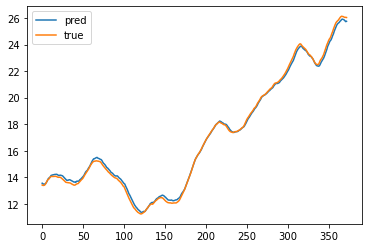

Alpha* = 0.3
Huber RMSE =  5.7212854093644205


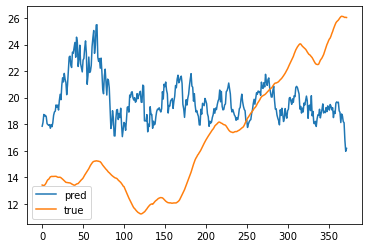

Random Forest Efficient Estimator = 960
Random Forest Validation RMSE = 0.6157636573483516
RandomForest RMSE =  5.884487092959528


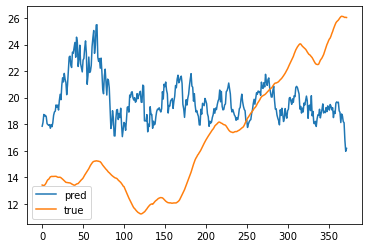

In [68]:
features = feat_1992
regime = reg_92_99
p_r1_preds, p_r1_errors, p_r1_hyper = regression_models(features, regime, target, freq1, pca1)

Regime 2

Lasso Alpha* = 0.05
Lasso Validation RMSE = 0.787981690970238
Lasso RMSE =  0.04620604599209574


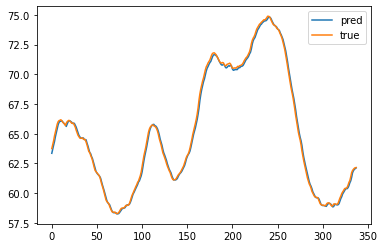

Huber Alpha* = 0.6000000000000001
Huber Validation RMSE = 7.577579801393161
Huber RMSE =  20.808921585552465


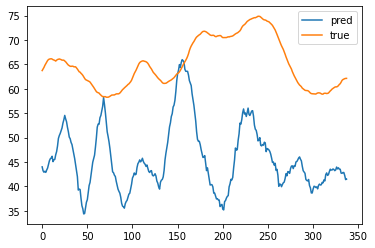

Random Forest Efficient Estimator = 970
Random Forest Validation RMSE = 3.0966647778534453
RandomForest RMSE =  7.23372490742359


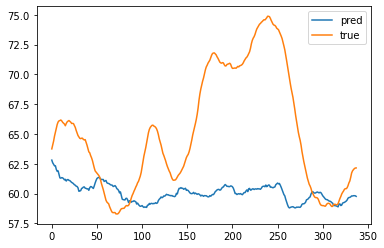

In [77]:
features = feat_2000
regime = reg_00_06
p_r2_preds, p_r2_errors, p_r2_hyper = regression_models(features, regime, target, freq1, pca1)

Regime 3

Lasso Alpha* = 0.05
Lasso Validation RMSE = 0.9812910196785009
Lasso Test RMSE =  0.08398456302485134


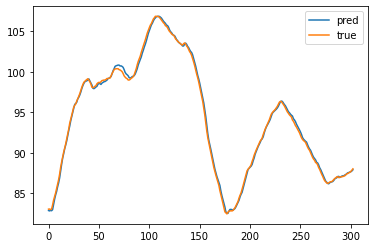

Huber Alpha* = 0.2
Huber Validation RMSE = 22.698234239892756
Huber Test RMSE =  18.324869278251157


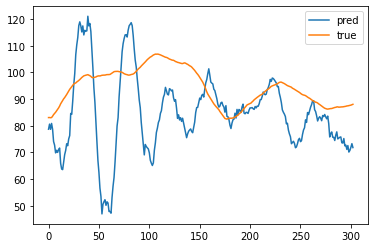

Random Forest Efficient Estimator = 960
Random Forest Validation RMSE = 1.0911417768835816
RandomForest Test RMSE =  9.820500442597439


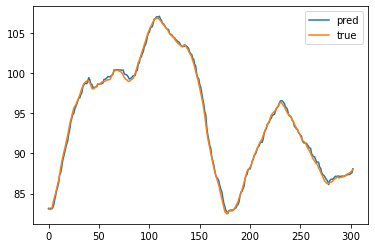

In [79]:
features = feat_2002
regime = reg_07_12
p_r3_preds, p_r3_errors, p_r3_hyper = regression_models(features, regime, target, freq1, pca1)

Regime 4

Lasso Alpha* = 0.05
Lasso Validation RMSE = 0.5088615022066948
Lasso Test RMSE =  0.1891279317124633


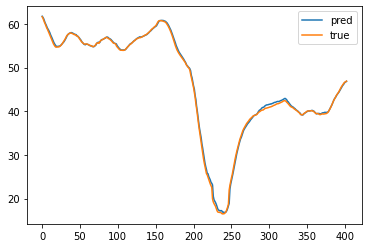

Huber Alpha* = 0.5
Huber Validation RMSE = 29.5873691672655
Huber Test RMSE =  30.363879473326378


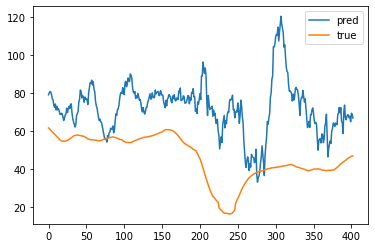

Random Forest Efficient Estimator = 980
Random Forest Validation RMSE = 0.738522846695992
RandomForest Test RMSE =  15.45444337803657


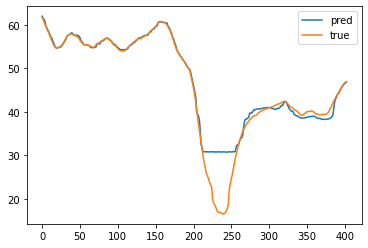

In [80]:
features = feat_2002
regime = reg_13_20
p_r4_preds, p_r4_errors, p_r4_hyper = regression_models(features, regime, target, freq1, pca1)

**With PCA**

In [96]:
pca2=True

Regime 1

In [ ]:
features = feat_1992
regime = reg_92_99
p_r1_pca_preds, p_r1_pca_errors, p_r1_pca_hyper = regression_models(features, regime, target, freq1, pca2)

Regime 2

In [ ]:
features = feat_2000
regime = reg_00_06
p_r2_pca_preds, p_r2_pca_errors, p_r2_pca_hyper = regression_models(features, regime, target, freq1, pca2)

Regime 3

In [ ]:
features = feat_2002
regime = reg_07_12
p_r3_pca_preds, p_r3_pca_errors, p_r3_pca_hyper = regression_models(features, regime, target, freq1, pca2)

Regime 4

In [ ]:
features = feat_2002
regime = reg_13_20
p_r4_pca_preds, p_r4_pca_errors, p_r4_pca_hyper = regression_models(features, regime, target, freq1, pca2)

### Weekly

In [129]:
freq2='weekly'
pca1=False

Regime 1

Lasso Alpha* = 0.05
Lasso Validation RMSE = 0.3450030712456642
Lasso Test RMSE =  0.4769648184187754


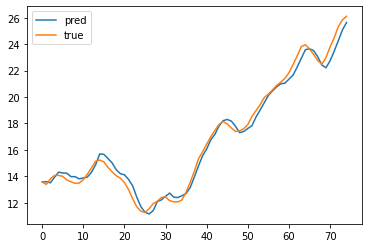

Huber Alpha* = 0.25
Huber Validation RMSE = 2.6792508046840173
Huber Test RMSE =  5.584897478366301


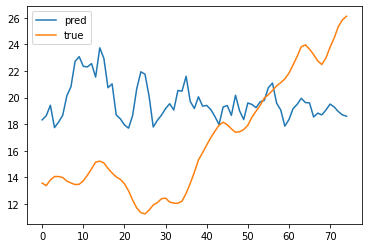

Random Forest Efficient Estimator = 980
Random Forest Validation RMSE = 0.8382857220511731
RandomForest Test RMSE =  5.592149101713936


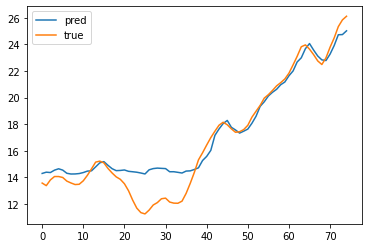

In [136]:
features = feat_1992
regime = reg_92_99
w_p_r1_preds, w_p_r1_errors, w_p_r1_hyper = regression_models(features, regime, target, freq2, pca1)

Regime 2

Lasso Alpha* = 0.05
Lasso Validation RMSE = 0.8146851746564917
Lasso Test RMSE =  1.2042204037480289


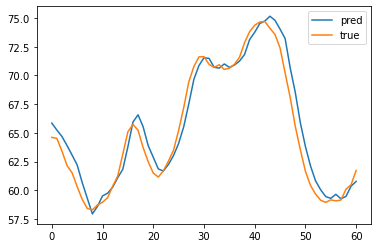

Huber Alpha* = 0.05
Huber Validation RMSE = 8.465180360892383
Huber Test RMSE =  21.638168717705955


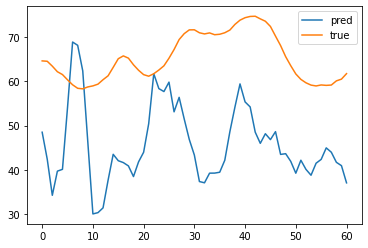

Random Forest Efficient Estimator = 970
Random Forest Validation RMSE = 3.1763796330675085
RandomForest Test RMSE =  7.414677867572807


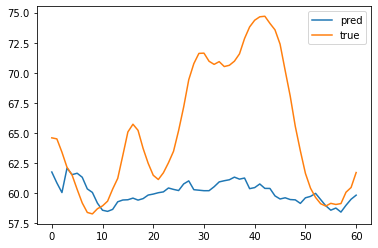

In [137]:
features = feat_2000
regime = reg_00_06
w_p_r2_preds, w_p_r2_errors, w_p_r2_hyper = regression_models(features, regime, target, freq2, pca1)

Regime 3

Lasso Alpha* = 0.05
Lasso Validation RMSE = 1.7591929268924997
Lasso Test RMSE =  1.219165921949817


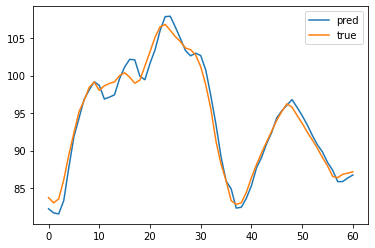

Huber Alpha* = 0.1
Huber Validation RMSE = 23.6167741549013
Huber Test RMSE =  17.130434787587593


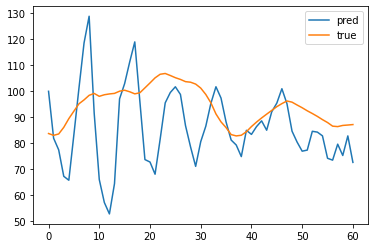

Random Forest Efficient Estimator = 990
Random Forest Validation RMSE = 1.3230701798354243
RandomForest Test RMSE =  10.147201514862141


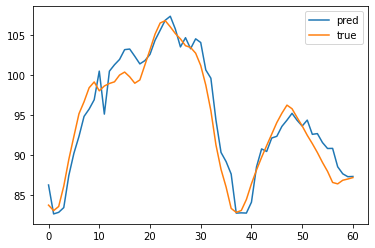

In [138]:
features = feat_2002
regime = reg_07_12
w_p_r3_preds, w_p_r3_errors, w_p_r3_hyper = regression_models(features, regime, target, freq2, pca1)

Regime 4

Lasso Alpha* = 0.05
Lasso Validation RMSE = 1.5153772151678087
Lasso Test RMSE =  1.9976276425111867


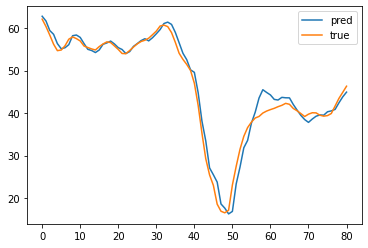

Huber Alpha* = 0.15000000000000002
Huber Validation RMSE = 30.449627004533497
Huber Test RMSE =  31.354357707541514


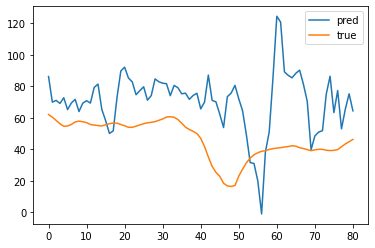

Random Forest Efficient Estimator = 970
Random Forest Validation RMSE = 0.575719590189622
RandomForest Test RMSE =  15.314088058659868


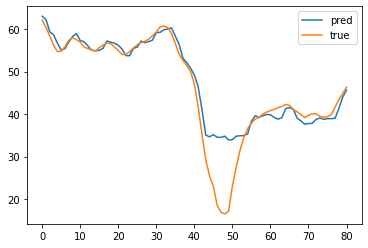

In [139]:
features = feat_2002
regime = reg_13_20
w_p_r4_preds, w_p_r4_errors, w_p_r4_hyper = regression_models(features, regime, target, freq2, pca1)

**With PCA**

In [88]:
pca2=True

Regime 1

PCA reduced features from 41 to 14
Error = 555.7699568725349
Lasso Alpha* = 0.15000000000000002
Lasso Validation RMSE = 2.8022949685600205
Lasso Test RMSE =  60.08451696387714


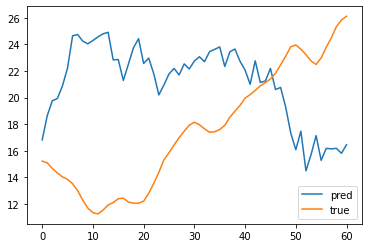

Huber Alpha* = 0.8500000000000001
Huber Validation RMSE = 3.0143212885853656
Huber Test RMSE =  8.088844872865977


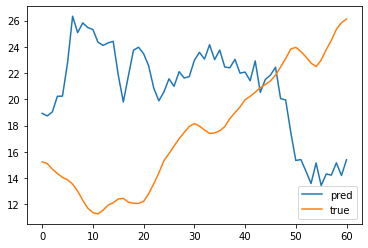

Random Forest Efficient Estimator = 950
Random Forest Validation RMSE = 1.3187591055862042
RandomForest Test RMSE =  4.944662925311969


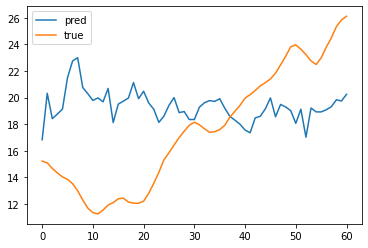

In [108]:
features = feat_1992
regime = reg_92_99
w_p_r1_pca_preds, w_p_r1_pca_errors, w_p_r1_pca_hyper = regression_models(features, regime, target, freq2, pca2)

Regime 2

PCA reduced features from 51 to 17
Error = 1276.4636545606838
Lasso Alpha* = 0.15000000000000002
Lasso Validation RMSE = 8.030297352401105
Lasso Test RMSE =  631.4718038030087


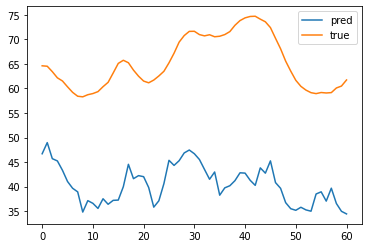

Huber Alpha* = 0.7000000000000001
Huber Validation RMSE = 8.475644342765232
Huber Test RMSE =  36.91299398782945


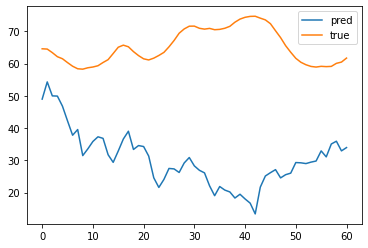

Random Forest Efficient Estimator = 990
Random Forest Validation RMSE = 33.92383018483217
RandomForest Test RMSE =  29.462249169665007


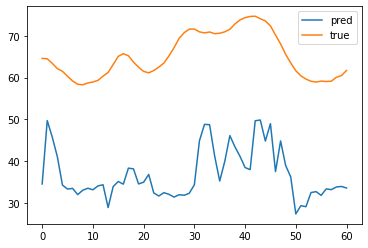

In [109]:
features = feat_2000
regime = reg_00_06
w_p_r2_pca_preds, w_p_r2_pca_errors, w_p_r2_pca_hyper = regression_models(features, regime, target, freq2, pca2)

Regime 3

PCA reduced features from 53 to 18
Error = 948.1747217293318
Lasso Alpha* = 0.2
Lasso Validation RMSE = 17.111104444729158
Lasso Test RMSE =  18.77604410796075


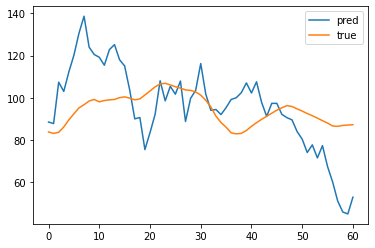

Huber Alpha* = 0.7000000000000001
Huber Validation RMSE = 17.176162357434112
Huber Test RMSE =  21.427539748514924


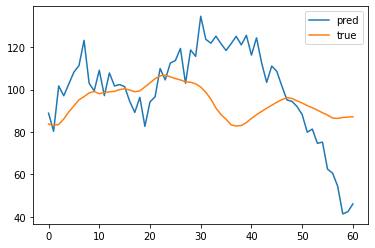

Random Forest Efficient Estimator = 970
Random Forest Validation RMSE = 9.497717304744766
RandomForest Test RMSE =  13.856508619915093


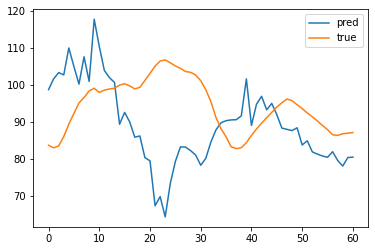

In [112]:
features = feat_2002
regime = reg_07_12
w_p_r3_pca_preds, w_p_r3_pca_errors, w_p_r3_pca_hyper = regression_models(features, regime, target, freq2, pca2)

Regime 4

PCA reduced features from 53 to 18
Error = 1723.4983487064767
Lasso Alpha* = 0.5
Lasso Validation RMSE = 20.73412794897719
Lasso Test RMSE =  34.946647093239136


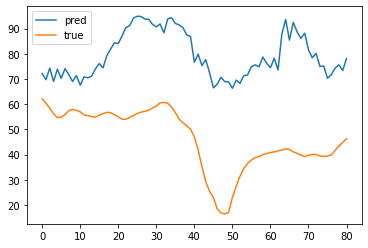

Huber Alpha* = 0.9000000000000001
Huber Validation RMSE = 27.784074639991413
Huber Test RMSE =  57.19841686451921


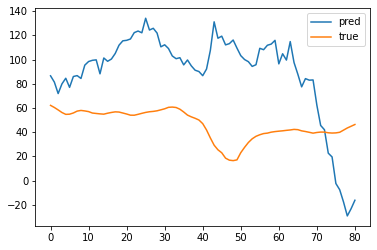

Random Forest Efficient Estimator = 980
Random Forest Validation RMSE = 5.373745139584556
RandomForest Test RMSE =  28.419512756106734


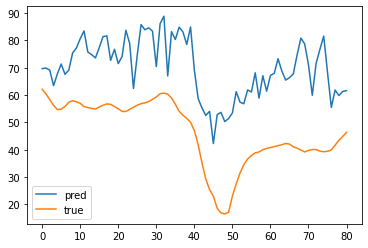

In [113]:
features = feat_2002
regime = reg_13_20
w_p_r4_pca_preds, w_p_r4_pca_errors, w_p_r4_pca_hyper = regression_models(features, regime, target, freq2, pca2)